In [62]:
#### Articles Used to Generate Code
#https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184
#https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/

In [63]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [127]:
import os
import cv2
import dlib
from google.colab.patches import cv2_imshow
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [65]:
SYM_PATH = '/content/drive/MyDrive/DeepFakeDetection'
%cd $SYM_PATH
%pip install -e .

/content/drive/MyDrive/DeepFakeDetection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/DeepFakeDetection
  Attempting uninstall: DeepFake
    Found existing installation: DeepFake 0.1.0
    Can't uninstall 'DeepFake'. No files were found to uninstall.
  Running setup.py develop for DeepFake


In [66]:
#from drive.MyDrive.DeepFakeDetection.packages.DlibManager import DlibManager

from packages.DlibManager import DlibManager

In [67]:
video_path = '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.mp4'
video = cv2.VideoCapture(video_path)

predictor_path = '/content/drive/MyDrive/DeepFakeDetection/model/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [68]:
audio_path = '/content/drive/MyDrive/DeepFakeDetection/data/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.wav'
audio, sample_rate = librosa.load(audio_path)

In [69]:
vid1_dlib = DlibManager(predictor, detector, video)

In [70]:
#resize all the lip frames to 70 x 90
lip_frames_resized = []
for frame in vid1_dlib.lip_frames:
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  resized_frame = cv2.resize(frame, (90, 70))
  lip_frames_resized.append(resized_frame)
lip_frames_resized = np.array(lip_frames_resized)

In [71]:
reshape_lip_frames = lip_frames_resized.reshape(lip_frames_resized.shape[0], lip_frames_resized.shape[1]*lip_frames_resized.shape[2])


In [72]:
#scalar = StandardScaler()
#centered_lip_frames = scalar.fit_transform(reshape_lip_frames)

avg_lip_frames = np.mean(reshape_lip_frames, axis=0)
centered_lip_frames = reshape_lip_frames - avg_lip_frames

In [73]:
pca = PCA()
pca_lip_frames = pca.fit_transform(centered_lip_frames)

In [74]:
random_samples = np.random.choice(np.arange(0, reshape_lip_frames.shape[0]), 5)
random_samples

array([191,  20,  28,  35,  75])

In [75]:
def reconstruction(pca, num_components, centered_data, mean, image_idx, height=70, width=90):
  eigenfaces = pca.components_[:num_components]
  samples, features = centered_data.shape
  weights = np.dot(centered_data, eigenfaces.T)
  recovered_image = (np.dot(weights[image_idx,:], eigenfaces)+mean).reshape(height, width)
  return recovered_image



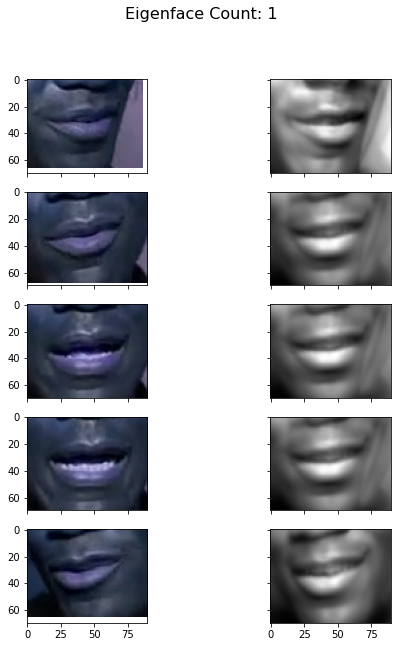

In [76]:
fig, axes = plt.subplots(5,2,sharex=True,sharey=True,figsize=(8,10))
fig.suptitle('Eigenface Count: 1', fontsize=16)
for idx, sample in enumerate(random_samples):
  orig = vid1_dlib.lip_frames[sample]
  reconstructed = reconstruction(pca, 1, centered_lip_frames, avg_lip_frames, sample)
  axes[idx, 0].imshow(orig)
  axes[idx, 1].imshow(reconstructed, cmap="gray")
plt.show()
  

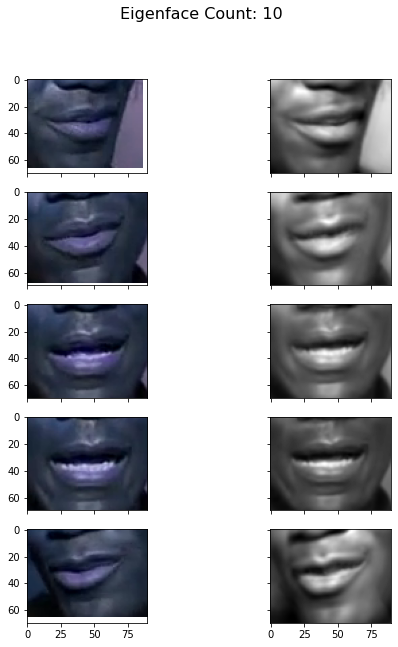

In [77]:
fig, axes = plt.subplots(5,2,sharex=True,sharey=True,figsize=(8,10))
fig.suptitle('Eigenface Count: 10', fontsize=16)
for idx, sample in enumerate(random_samples):
  orig = vid1_dlib.lip_frames[sample]
  reconstructed = reconstruction(pca, 10, centered_lip_frames, avg_lip_frames, sample)
  axes[idx, 0].imshow(orig)
  axes[idx, 1].imshow(reconstructed, cmap="gray")
plt.show()
  

In [78]:
mfcc_features = librosa.feature.mfcc(y=audio, hop_length=int(sample_rate*librosa.get_duration(audio)/251)).T[:251, :]

In [80]:
coef_one_mfcc = mfcc_features[:, 0].reshape(251, 1)

In [112]:
weights.shape

(251, 10)

In [113]:
coef_one_mfcc.shape


(251,)

In [118]:
eigenfaces = pca.components_[:10]
samples, features = centered_lip_frames.shape
weights = np.dot(centered_lip_frames, eigenfaces.T)

train_test_data = np.hstack((weights, coef_one_mfcc.reshape(251, 1)))

(251, 11)


In [124]:
X_train, X_test, y_train, y_test = train_test_split(weights, coef_one_mfcc, test_size=0.15, random_state=12)

In [129]:
model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
err = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))/len(pred)
print(err)

1.3076305393893473


In [130]:
coef_one_mfcc

array([-296.41904, -279.21863, -298.12906, -293.69284, -305.2059 ,
       -345.8577 , -301.43817, -229.05885, -261.20306, -300.61206,
       -349.79593, -372.80948, -357.33502, -369.76245, -366.0865 ,
       -372.3605 , -370.7783 , -363.96356, -367.84128, -370.55408,
       -393.25925, -439.06146, -464.73755, -432.66553, -404.9073 ,
       -413.2059 , -422.8205 , -426.31177, -434.841  , -439.7593 ,
       -337.45334, -253.05904, -217.40215, -210.67944, -219.60132,
       -231.21301, -228.89075, -220.46054, -207.26813, -225.51196,
       -249.9108 , -342.2    , -345.67267, -335.40952, -351.67914,
       -358.56274, -346.6428 , -357.26965, -252.23682, -199.9593 ,
       -199.89233, -207.30766, -218.52931, -247.36679, -336.5181 ,
       -315.27512, -252.74985, -247.29808, -263.25406, -329.97195,
       -369.59854, -345.16794, -338.5035 , -357.01038, -389.1738 ,
       -420.45142, -406.04907, -371.97537, -380.8356 , -366.86826,
       -282.97693, -284.00452, -327.68677, -349.73923, -283.74